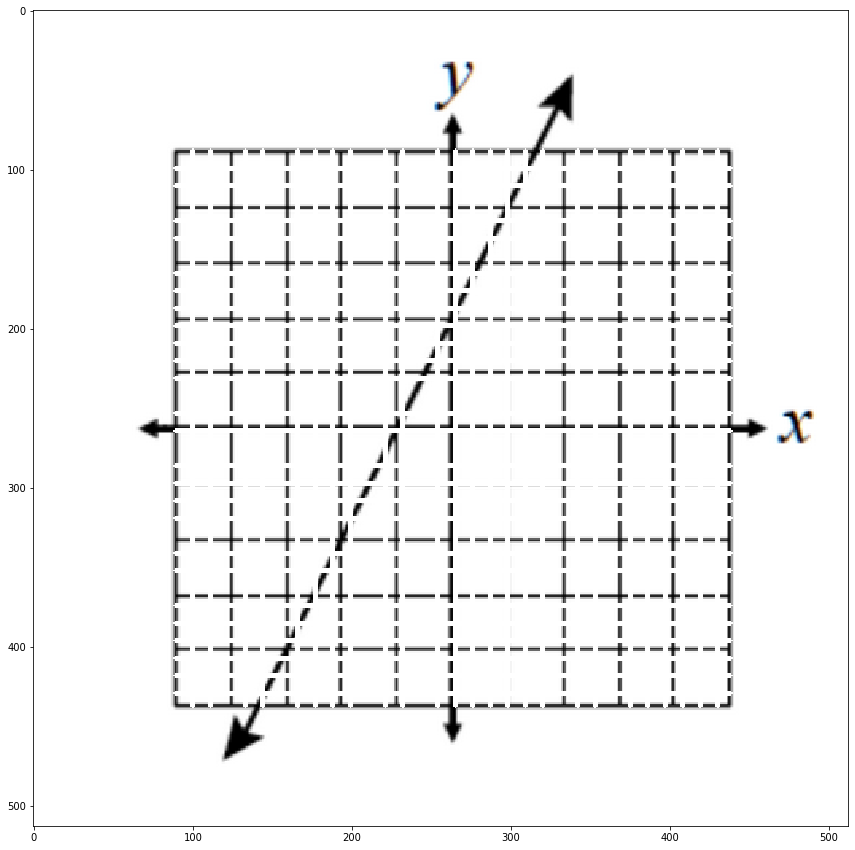

In [100]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pytesseract
from pytesseract import Output
plt.rcParams['figure.figsize'] = [20, 15]


def white(color):
    return color>=250
    white_threshold=250
    return color[0]>=white_threshold and color[1]>=white_threshold and color[2]>=white_threshold


def find_grid_bounds(img):
    y_end, x_end = img.shape[:2]
    y_end-=1
    x_end-=1
    '''
    bound = {
        'x_start':0,
        'y_start':0,
        'x_end':x_end,
        'y_end':y_end,
    }
    cv2.rectangle(img,(bound['x_start'],bound['y_start']),(bound['x_end'],bound['y_end']),(0,255,0),2)
    plt.imshow(img)
    '''
    x_start, y_start = 0,0
    curx = x_start
    cury = y_start
    bound = {}
    while curx<x_end:
        found=False
        cury=y_start
        while cury<y_end and white(img[cury,curx]):
            cury+=1
        if not cury>=y_end/2:
            found=True
            break
        if found:
            break
        curx+=1
    bound['x_start']=curx
    bound['y_start']=cury
    
    cury=y_end
    curx=x_end
    while curx>=0:
        found=False
        cury=y_end
        while cury>=0 and white(img[cury,curx]):
            cury-=1
        if cury>(2*y_end)/3:
            found=True
            break
        if found:
            break
        curx-=1
    bound['x_end']=curx
    bound['y_end']=cury
    return bound
    #cv2.rectangle(img,(bound['x_start'],bound['y_start']),(bound['x_end'],bound['y_end']),(0,255,0),2)
    #plt.imshow(img)

def get_axis_size_in_grids(bounds,grid_size):
    return int((bounds['y_end']-bounds['y_start']-grid_size)/grid_size) + 1

def grid_has_content(img,sx,sy,size):
    return True

def process_all_grids(img,sx,sy,grid_size,axis_size_in_grids):
    for grid_x in range(axis_size_in_grids):
        for grid_y in range(axis_size_in_grids):
            cursx = sx + grid_x*grid_size
            cursy = sy + grid_y*grid_size
            if grid_has_content(img,cursx,cursy,grid_size):
                #print("content found")
                cv2.rectangle(img,(cursx,cursy),(cursx+grid_size,cursy+grid_size),(0,255,0),2)

def overlay_grid(img,bounds):
    gap=11
    white=(255,255,255)
    thickness=2
    grid_size=30
    err=5
    for x in range(bounds['x_start']+gap,bounds['x_end']+1,gap):
        if x%30<=err:
            continue
        cv2.line(img, (x, bounds['y_start']), (x, bounds['y_end']), white, thickness)
    for y in range(bounds['y_start']+gap,bounds['y_end']+1,gap):
        if y%30<=err:
            continue
        cv2.line(img, (bounds['x_start'],y), (bounds['x_end'],y), white, thickness)
    
def find_grid_size(img,bounds):
    #clearing line
    err = 15
    x = bounds['x_start']
    y = bounds['y_start'] + err
    while not white(img[y,x]):
        x+=1
    size=0
    while white(img[y,x]):
        x+=1
        size+=1
    sx,sy = bounds['x_start'],bounds['y_start']
    sx+=1
    sy+=1
    return sx,sy,size+1
img=cv2.imread('linegraph.png')
grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
(thresh, bwImage) = cv2.threshold(grayImage, 127, 255, cv2.THRESH_BINARY)
plt.imshow(bwImage)
bounds = find_grid_bounds(bwImage)
sx,sy,grid_size = find_grid_size(bwImage,bounds)
#cv2.rectangle(img,(sx+2*size,sy),(sx+3*size,sy+size),(0,255,0),2)
#plt.imshow(img)
axis_size_in_grids = get_axis_size_in_grids(bounds,grid_size)
#process_all_grids(img,sx,sy,grid_size,axis_size_in_grids)
overlay_grid(img,bounds)
plt.imshow(img)

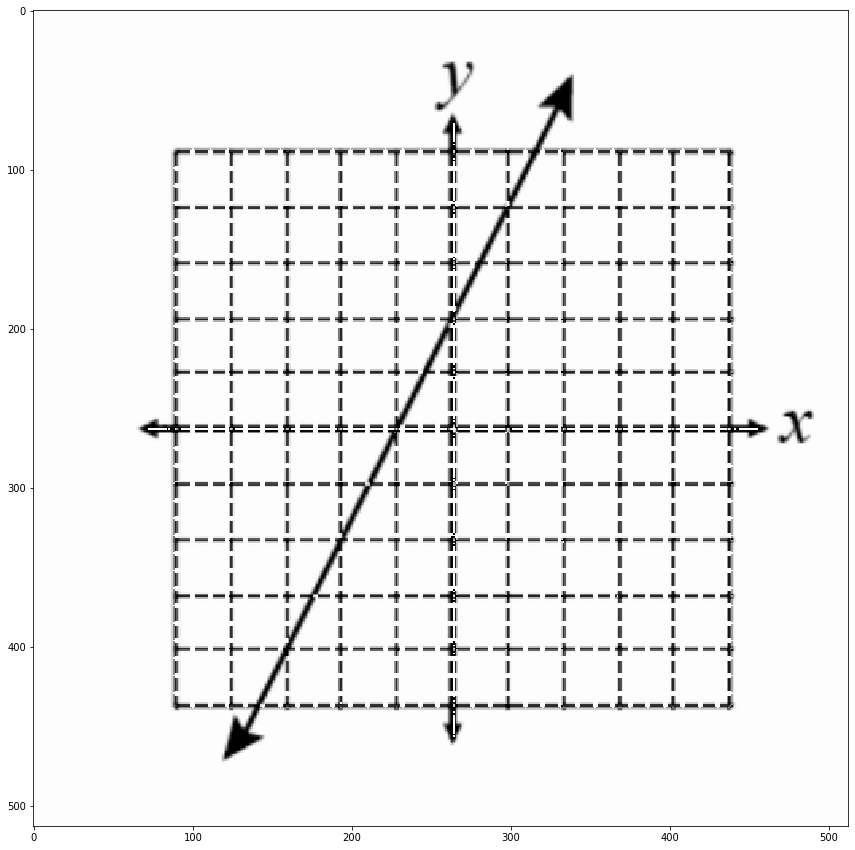

In [184]:
def overlay_grid(img,bounds,typ):
    gap=11
    white=(255,255,255)
    thickness=2
    grid_size=30
    err=5
    if typ=='hor':
        for x in range(bounds['x_start']+gap,bounds['x_end']+1,gap):
            cv2.line(img, (x, bounds['y_start']), (x, bounds['y_end']), 255, thickness)
    if typ=='ver':
        for y in range(bounds['y_start']+gap,bounds['y_end']+1,gap):
            cv2.line(img, (bounds['x_start'],y), (bounds['x_end'],y), 255, thickness)

img = cv2.imread('linegraph.png')
kernel = np.ones((1,1),np.uint8)
plt.imshow(cv2.erode(img,kernel,15),cmap=plt.cm.gray)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
kernel_y = np.ones((100,1), np.uint8)
kernel_x = np.ones((1,100), np.uint8)
yaxis = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel_y)
xaxis = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel_x)
line = cv2.add(gray, (255-xaxis-yaxis))
#opening = cv2.morphologyEx(dst, cv2.MORPH_OPEN, kernel)
ret, thresh_img = cv2.threshold(line, 180, 255, cv2.THRESH_BINARY)
median = cv2.medianBlur(thresh_img, 5)
#plt.imshow(median, cmap = plt.cm.gray)
overlay_grid(yaxis,bounds,"ver")
overlay_grid(xaxis,bounds,"hor")

#plt.imshow(median)
plt.rcParams['figure.figsize'] = [20, 15]
dst = cv2.add(-line, -(xaxis+yaxis))
plt.imshow(-dst,cmap = plt.cm.gray)
#plt.imshow(line, cmap = plt.cm.gray)
#plt.savefig("test.png")
#plt.imshow(cv2.morphologyEx(median, cv2.MORPH_CLOSE, np.ones((20,20),np.uint8)))


### 

/home/mj/anaconda3/envs/cs682/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


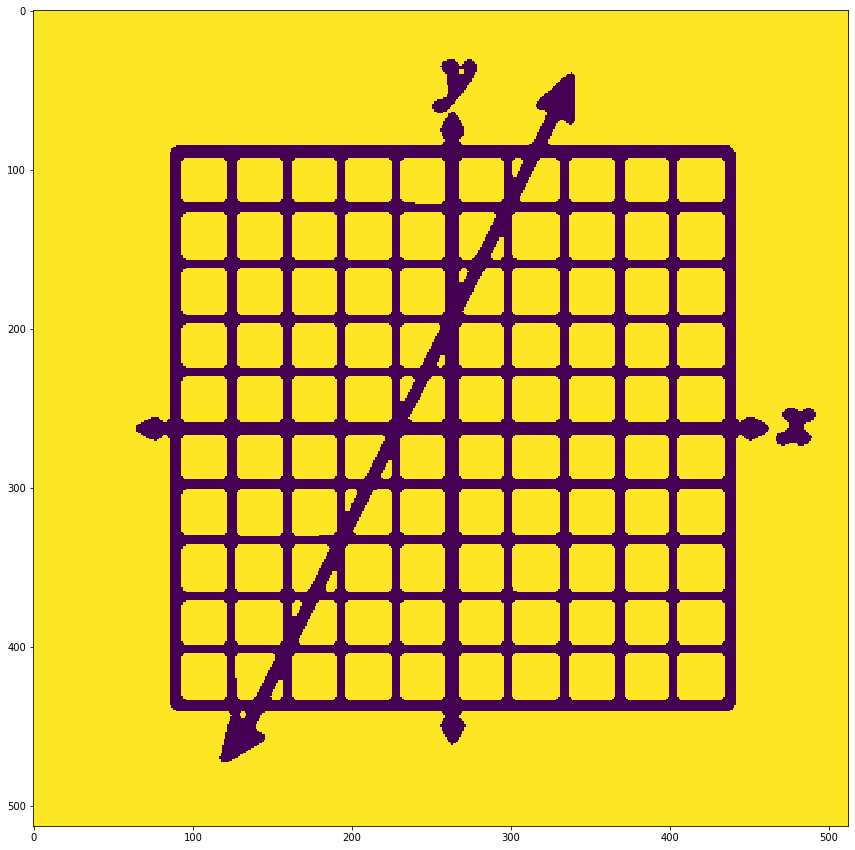

In [103]:
import cv2
import numpy
import sys

BLOCK_SIZE = 30
THRESHOLD = 5


def preprocess(image):
    image = cv2.medianBlur(image, 3)
    image = cv2.GaussianBlur(image, (3, 3), 0)
    return 255 - image


def postprocess(image):
    image = cv2.medianBlur(image, 5)
    # image = cv2.medianBlur(image, 5)
    # kernel = numpy.ones((3,3), numpy.uint8)
    # image = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    return image


def get_block_index(image_shape, yx, block_size): 
    y = numpy.arange(max(0, yx[0]-block_size), min(image_shape[0], yx[0]+block_size))
    x = numpy.arange(max(0, yx[1]-block_size), min(image_shape[1], yx[1]+block_size))
    return numpy.meshgrid(y, x)


def adaptive_median_threshold(img_in):
    med = numpy.median(img_in)
    img_out = numpy.zeros_like(img_in)
    img_out[img_in - med < THRESHOLD] = 255
    return img_out


def block_image_process(image, block_size):
    out_image = numpy.zeros_like(image)
    for row in range(0, image.shape[0], block_size):
        for col in range(0, image.shape[1], block_size):
            idx = (row, col)
            block_idx = get_block_index(image.shape, idx, block_size)
            out_image[block_idx] = adaptive_median_threshold(image[block_idx])

    return out_image


def process_image_file(filename):
    image_in = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2GRAY)

    image_in = preprocess(image_in)
    image_out = block_image_process(image_in, BLOCK_SIZE)
    image_out = postprocess(image_out)
    plt.imshow(image_out)
    #cv2.imwrite('bin_' + filename, image_out)

process_image_file('linegraph.png')